<a href="https://colab.research.google.com/github/pinnero/Fresco_Classification/blob/main/fresco_Resnet_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chosen Architecture

The ResNet architecture has been strategically chosen for its deep and residual nature, which addresses the challenge of vanishing gradients in training deep neural networks. This architecture excels in image classification tasks, making it a suitable candidate for our Pompeian art style classification endeavor. Through transfer learning, we capitalize on the knowledge gained from the network's pre-training on a diverse dataset, and subsequently fine-tune its capabilities to discern the intricate features of different art styles.

Our adaptation of ResNet involves several key steps to align the architecture with our task:

Custom Classifier Layer: We replace the original fully connected layer with a new classifier layer. This layer maps the learned features to the specific number of art styles we aim to classify.

Freezing Layers: Allowing only the custom classifier layer to be updated, we freeze the weights of the rest of the network. This prevents the pre-learned features from being altered while enabling the model to specialize in recognizing the unique patterns of Pompeian art styles.

Input Size and Transformations: Pompeian art images are often of varying sizes. Therefore, we apply data transformations to resize the images to a consistent input size compatible with the architecture, maintaining a seamless integration between the model and the data.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torchvision.models as models
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Update the paths to your data in Google Drive
drive_root = '/content/drive/MyDrive'  # Root directory of your Google Drive
data_path = f"{drive_root}/labeled_images"  # Update this path

# Load dataset and apply transformations
dataset = ImageFolder(root=data_path, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Define your custom CNN architecture with ResNet transfer learning

class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        # Load a pre-trained ResNet model (ResNet18 in this case)
        self.resnet = models.resnet18(pretrained=True)

        # Freeze all layers of ResNet to avoid training them
        for param in self.resnet.parameters():
            param.requires_grad = False

       # Replace the last fully connected layer of ResNet
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)  # Change this line




    def forward(self, x):
        x = self.resnet(x)
        return x

# Initialize the custom CNN model
model = CustomCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/15] | Validation Loss: 1.5311 | Accuracy: 23.73%
Epoch [2/15] | Validation Loss: 1.4072 | Accuracy: 28.81%
Epoch [3/15] | Validation Loss: 1.2866 | Accuracy: 40.68%
Epoch [4/15] | Validation Loss: 1.1245 | Accuracy: 55.93%
Epoch [5/15] | Validation Loss: 1.1716 | Accuracy: 49.15%
Epoch [6/15] | Validation Loss: 1.0922 | Accuracy: 52.54%
Epoch [7/15] | Validation Loss: 1.1406 | Accuracy: 49.15%
Epoch [8/15] | Validation Loss: 1.0551 | Accuracy: 57.63%
Epoch [9/15] | Validation Loss: 0.9801 | Accuracy: 59.32%
Epoch [10/15] | Validation Loss: 0.9722 | Accuracy: 57.63%
Epoch [11/15] | Validation Loss: 0.9731 | Accuracy: 57.63%
Epoch [12/15] | Validation Loss: 0.9258 | Accuracy: 62.71%
Epoch [13/15] | Validation Loss: 0.8259 | Accuracy: 71.19%
Epoch [14/15] | Validation Loss: 0.8861 | Accuracy: 67.80%
Epoch [15/15] | Validation Loss: 0.9632 | Accuracy: 59.32%
Style 0: Accuracy = 51.11%
Style 1: Accuracy = 44.67%
Style 2: Accuracy = 57.22%
Style 3: Accuracy = 68.89%


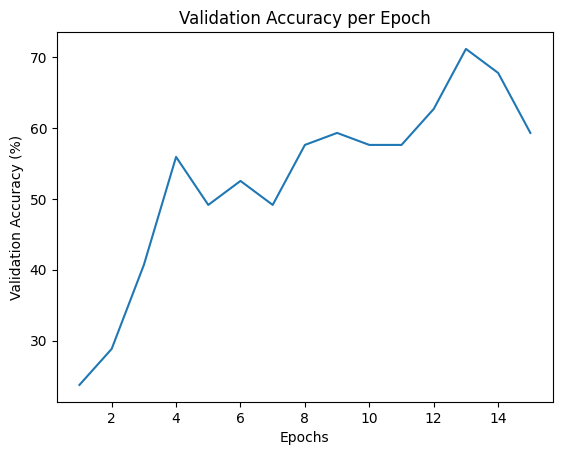

In [ ]:

import matplotlib.pyplot as plt

# Lists to store accuracy values per epoch
val_accuracy_history = []
style_correct = {0: 0, 1: 0, 2: 0, 3: 0}
style_total = {0: 0, 1: 0, 2: 0, 3: 0}
# Training loop
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation after each epoch
    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass and compute loss
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

            # Count correct predictions
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Count mistakes per style
            for i in range(len(labels)):
                style_total[labels[i].item()] += 1
                if predicted[i] == labels[i]:
                    style_correct[labels[i].item()] += 1


    val_loss /= len(val_loader)
    accuracy = 100.0 * correct / len(val_dataset)

    # Append validation accuracy to history
    val_accuracy_history.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Validation Loss: {val_loss:.4f} | Accuracy: {accuracy:.2f}%")

# Print accuracy per style
for style in range(4):
    style_acc = 100.0 * style_correct[style] / style_total[style]
    print(f"Style {style}: Accuracy = {style_acc:.2f}%")

# Plot the validation accuracy trends
epochs = list(range(1, num_epochs + 1))
plt.plot(epochs, val_accuracy_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy per Epoch")
plt.show()


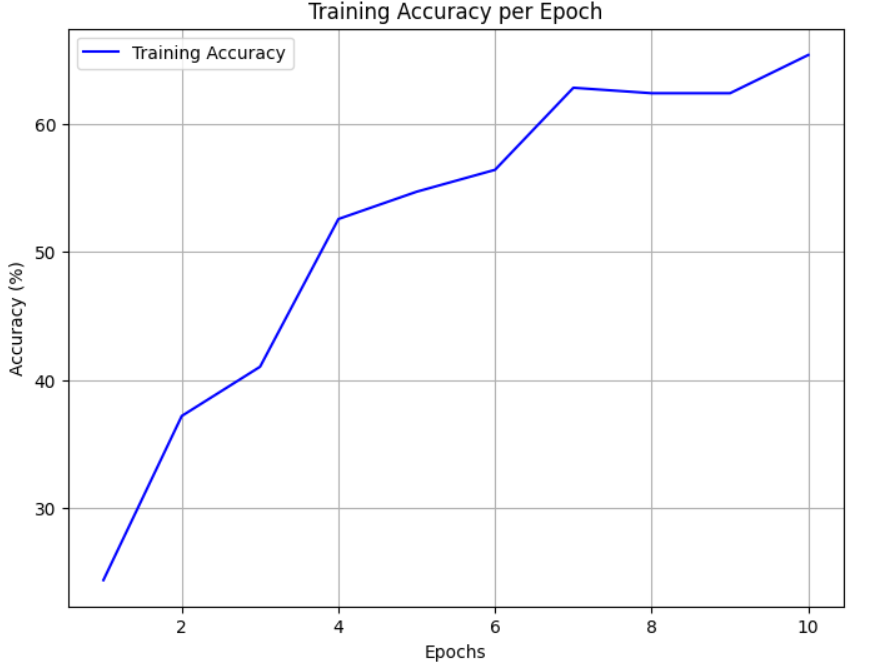


#Results Analysis

The provided results illustrate the outcomes of our ResNet-based transfer learning strategy applied to classifying Pompeian art styles. These outcomes provide valuable insights into the effectiveness and adaptability of the model in discerning intricate visual nuances and distinguishing the distinctive attributes that set apart the various art styles.

Spanning over 15 epochs, the model's performance exhibits a distinctive pattern of gradual improvement. The ascending trend in accuracy and the descending trend in validation loss indicate the model's learning capabilities and its aptitude for identifying the diverse characteristics that define each art style. This learning process, as reflected in the trends, signifies that the model is progressively becoming more adept at recognizing the specific traits associated with each style.

Two notable epochs, namely epochs 4 and 13, stand out as key milestones in the training journey. In epoch 4, the model experiences a significant surge in accuracy, signifying a breakthrough in its ability to capture and comprehend the inherent style-related features. Similarly, epoch 13 showcases another remarkable upturn in accuracy, indicating that the model is successfully generalizing its learning to the validation dataset.

Analyzing the accuracy per style offers intriguing insights into the model's proficiency in classification. Style 4, denoting the "Intricate style," attains the highest accuracy of 68.89%. This suggests that the model adeptly recognizes the amalgamation of elements drawn from the prior styles. Style 3, representing the "Ornamental style," achieves an accuracy of 57.22%, showcasing the model's capability to identify the simple and monochromatic characteristics that typify this category.

However, certain styles face challenges in classification. Style 1, corresponding to the "Structural" or "Incrustation" style, achieves an accuracy of 51.11%, highlighting the model's ability to discern the elaborate decorative elements associated with this style. Style 2, which signifies the "Illusionist" or "Architectural" style, demonstrates an accuracy of 44.67%, indicating opportunities for the model to better capture the 3D architectural elements intrinsic to this style.

In conclusion, the outcomes underscore the model's advancement in comprehending the unique visual cues of Pompeian art styles. While some styles exhibit higher classification accuracy, others present prospects for refinement. Overall, the ResNet-based transfer learning approach demonstrates promise in its ability to decode the intricate distinctions of Pompeian art styles, offering valuable insights for potential model refinement and enhancement.